In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed")

print("Path to dataset files:", path)

100%|██████████| 6.40G/6.40G [01:21<00:00, 84.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed/versions/1


In [ ]:
classes = os.listdir(path)
print("Classes:", classes)
for cls in classes:
    cls_path = os.path.join(path, cls)
    n_images = len(os.listdir(cls_path))
    print(f"{cls}: {n_images} images")

Classes: ['im_Dyskeratotic', 'im_Metaplastic', 'im_Parabasal', 'im_Superficial-Intermediate', 'im_Koilocytotic']
im_Dyskeratotic: 1 images
im_Metaplastic: 1 images
im_Parabasal: 1 images
im_Superficial-Intermediate: 1 images
im_Koilocytotic: 1 images


In [ ]:
import torch
from torchvision import datasets, transforms

# Define training augmentations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),         # resize all images
    transforms.RandomHorizontalFlip(p=0.5), # 50% chance to flip
    transforms.RandomRotation(15),          # rotate ±15 degrees
    transforms.ColorJitter(0.2, 0.2, 0.2),  # brightness, contrast, saturation
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), # random shear & scale
    transforms.ToTensor(),                  # convert to tensor
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]) # normalize to [-1,1]
])

# Validation/test transforms (only resize + normalize)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os

class SipakMedDataset(Dataset):
    def __init__(self, root_dir, transform=None, valid_ext=(".png", ".bmp", ".jpg", ".jpeg")):
        self.samples = []
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))

        for cls_idx, cls in enumerate(self.classes):
            cls_path = os.path.join(root_dir, cls, cls)
            for f in os.listdir(cls_path):
                if f.lower().endswith(valid_ext):
                    self.samples.append((os.path.join(cls_path, f), cls_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")  # use PIL for transforms
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
from torch.utils.data import DataLoader, random_split

dataset_path = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed"

# Full dataset with augmentations
full_dataset = SipakMedDataset(root_dir=path, transform=train_transform)

# Train/val split (80-20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply validation transform
val_dataset.dataset.transform = val_transform

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")


Train samples: 772, Val samples: 194


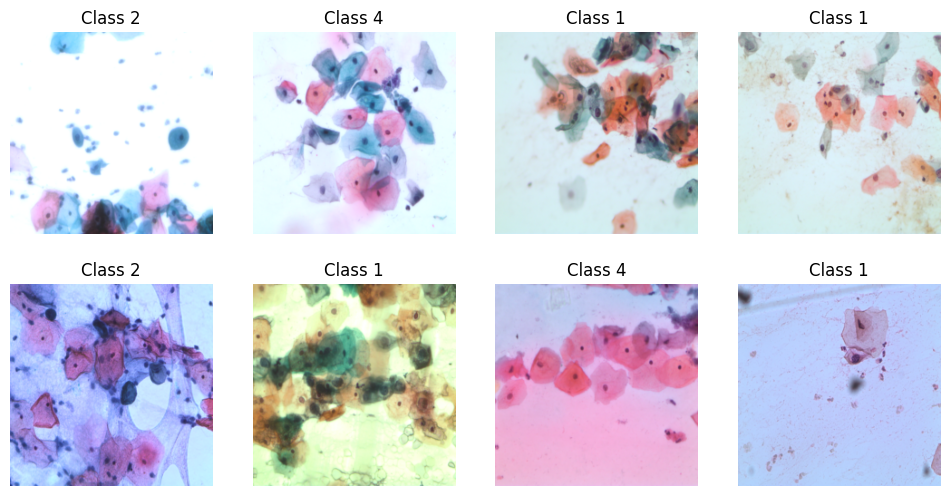

In [ ]:
import matplotlib.pyplot as plt

# Get one batch
images, labels = next(iter(train_loader))

# Show 8 images
plt.figure(figsize=(12, 6))
for i in range(8):
    img = images[i].permute(1, 2, 0).numpy()
    img = (img * 0.5) + 0.5  # denormalize back to [0,1]
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(f"Class {labels[i].item()}")
    plt.axis("off")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Replace final layer for 5 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)  # 5 classes in SipakMed

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 94.2MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        val_acc = evaluate(model, val_loader)

        print(f"Epoch {epoch+1}: Loss={running_loss/len(train_loader):.4f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total


In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


In [ ]:
torch.save(model.state_dict(), "sipakmed_resnet18.pth")


In [ ]:
from google.colab import files
uploaded = files.upload()  # choose a .png or .bmp from SipakMed
from PIL import Image
import torchvision.transforms as transforms

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])


In [ ]:
import torch

def predict_image(model, image_path, classes):
    image = Image.open(image_path).convert("RGB")
    img_tensor = val_transform(image).unsqueeze(0).to(device)  # add batch dim

    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, pred = torch.max(outputs, 1)

    predicted_class = classes[pred.item()]
    return predicted_class

# Classes (same order as dataset loader)
classes = sorted(os.listdir(dataset_path))

# Example prediction
image_path = "C Img (124).bmp"  # replace with your uploaded file name
prediction = predict_image(model, image_path, classes)
print(f"Predicted class: {prediction}")


In [ ]:
import matplotlib.pyplot as plt

image = Image.open(image_path).convert("RGB")
plt.imshow(image)
plt.title(f"Prediction: {prediction}")
plt.axis("off")
plt.show()


#Implementing Unet architecture

Downsampled: torch.Size([1, 64, 128, 128])
Skip: torch.Size([1, 64, 256, 256])


Output shape: torch.Size([1, 64, 128, 128])


Output shape: torch.Size([1, 21, 256, 256])


Loss: 3.0774450302124023
